In [1]:
from pathlib import Path
from src.xg_model_base import XGModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

## Logistic Regression

In [2]:
model = XGModel("../data", model=LogisticRegression())
model.fit(params=dict(penalty='l2', class_weight="balanced", max_iter=1000, C=0.01))

--> Logistic Regression:
train: AUC: 0.7464; RMSE: 0.2204


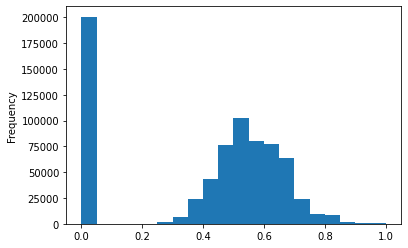

outcome    2794.000000
1          9451.879166
dtype: float64
test: AUC: 0.7427; RMSE: 0.2204


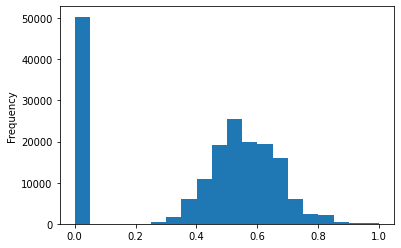

outcome     667.000000
1          2335.281535
dtype: float64


In [3]:
print("--> Logistic Regression:")
for ds_type in ['train', 'test']:
    print(ds_type, end=": ")
    x = model.get_norm_train_ds() if ds_type == "train" else model.get_norm_test_ds()
    y_true = model.y_train if ds_type == "train" else model.y_test
    y_xg = model.predict_xg(x)
    y_xg.index = y_true.index
    print(f"AUC: {roc_auc_score(y_true, y_xg):.4f}; RMSE: {mean_squared_error(y_true, y_xg):.4f}")
    y_xg.plot.hist(bins=20)
    plt.show()
    both = pd.concat([y_true, y_xg], axis='columns')
    print(both[both[1] > 0.8].sum())


## Neural Network

In [4]:
from src.xg_model_nn import XGModelNN
import tensorflow as tf
import seaborn as sns
import pandas as pd
print(tf.test.gpu_device_name())

/device:GPU:0


In [5]:
model = XGModelNN("../data", hidden_layers="64-256-64-16-8", dropout=0.2)
history = model.fit(n_epochs=100, batch_size=1024, verbose=0)

_squared_error: 0.4520
Epoch 4/100
564/564 [==============================] - 3s 5ms/step - loss: 0.0231 - auc: 0.7874 - root_mean_squared_error: 0.4506 - val_loss: 0.2003 - val_auc: 0.8036 - val_root_mean_squared_error: 0.4475
Epoch 5/100
564/564 [==============================] - 3s 5ms/step - loss: 0.0228 - auc: 0.7924 - root_mean_squared_error: 0.4493 - val_loss: 0.2024 - val_auc: 0.8050 - val_root_mean_squared_error: 0.4498
Epoch 6/100
564/564 [==============================] - 3s 5ms/step - loss: 0.0227 - auc: 0.7953 - root_mean_squared_error: 0.4489 - val_loss: 0.2022 - val_auc: 0.8089 - val_root_mean_squared_error: 0.4497
Epoch 7/100
564/564 [==============================] - 3s 5ms/step - loss: 0.0225 - auc: 0.7985 - root_mean_squared_error: 0.4467 - val_loss: 0.1937 - val_auc: 0.8123 - val_root_mean_squared_error: 0.4401
Epoch 8/100
564/564 [==============================] - 4s 7ms/step - loss: 0.0223 - auc: 0.8026 - root_mean_squared_error: 0.4450 - val_loss: 0.2042 - val_au

<AxesSubplot:ylabel='auc'>

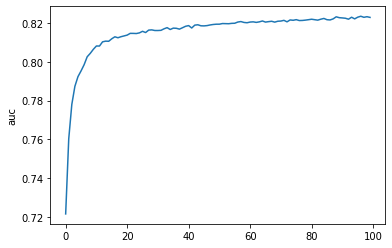

In [8]:
df_history = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=df_history, x=df_history.index, y="auc")


--> MLP:
train: AUC: 0.6864; RMSE: 0.1845


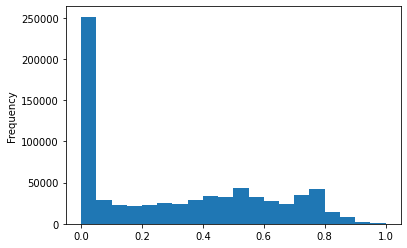

outcome    223726
0          223726
dtype: int64
test: AUC: 0.6847; RMSE: 0.1844


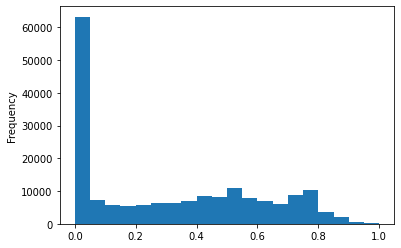

outcome    56160
0          56160
dtype: int64


In [15]:
print("--> MLP:")
for ds_type in ['train', 'test']:
    print(ds_type, end=": ")
    x = model.get_norm_train_ds() if ds_type == "train" else model.get_norm_test_ds()
    y_true = model.y_train if ds_type == "train" else model.y_test
    y_xg = model.predict_xg(x)
    y_xg.index = y_true.index
    print(f"AUC: {roc_auc_score(y_true, y_xg):.4f}; RMSE: {mean_squared_error(y_true, y_xg):.4f}")
    y_xg.plot.hist(bins=20)
    plt.show()
    both = pd.concat([y_true, y_xg], axis='columns')
    print(both[both[0] < 0.01].count())